# Symbolic Regression using KANs

This is Part 4 of the tutorial series on KAN. 

In our previous notebooks, we looked at the fundamental components of KANs, including spline activation functions and how to perform backpropagation in a network using such functions. We also explored the unique advantages of KANs, such as their capability for continual learning and enhancing model capacity.

In this notebook, we will learn how to train KANs when specific activation functions are predetermined and fixed to a symbolic formula. If a user is able to identify a spline that matches a certain symbolic function, that activation can be fixed to the identified symbolic formula, while the rest of the KAN continues to be trained.

Let's dive into this scenario.



In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
from utils import eval_basis_functions, get_coeff, single_stacked_kan_training

## Dataset

Let's create a dataset using the function example provided by the authors: $ f(x, y) = e^{\sin(\pi x) + (y+0.5)^2} $.

In [8]:
fn = lambda x: torch.exp(torch.sin(torch.pi * x[:, :1]) + torch.pow(x[:, 1:] + 0.5, 2))

x1 = torch.linspace(-1, 1, steps=40)
x2 = torch.linspace(-1, 1, steps=40)
x1, x2 = torch.meshgrid(x1, x2, indexing='ij')
x_eval = torch.stack([x1.flatten(), x2.flatten()], dim=1)
y_target = fn(x_eval) #+ torch.randn((x_eval.shape[0], 1))*0.1

# test and train split
n_training = int(x_eval.shape[0] * 0.8)
training_idxs = np.random.randint(x_eval.shape[0], size=n_training)
test_idxs = [i for i in range(x_eval.shape[0]) if i not in training_idxs]
x_training = x_eval[training_idxs]
x_test = x_eval[test_idxs]
y_training = y_target[training_idxs]
y_test = y_target[test_idxs]

print("Training dataset: ", n_training)
print("Test dataset: ", len(test_idxs))

Training dataset:  1280
Test dataset:  727


### Basic functions

Let's define some basic functions
1. `initialize_KAN` to setup a KAN using the parameters provided
2. `eval_KAN` to evaluate KAN for a given x
3. `eval_x_symbolically` to evaluate x given only the symbolic functions
4. `set_symbolic_fn` to set a particular activation function in KAN to a specified symbolic function

In [9]:
def initialize_KAN(KAN, k, grid_range, grid_size):
    """
    Returns the ingredients necessary to evaluate a KAN.
    Note: we use a single grid for all the activation functions.

    Args:
        KAN: List of integers corresponding to neurons in each layer
        k: spline order
        grid_range: range of grid. e.g, [-1, 1]
        grid_size: number of control points
    """
    grid = torch.linspace(grid_range[0], grid_range[1], steps=grid_size).unsqueeze(dim=0)
    
    # initialize the coefficients and symbolic functions
    coefs, masks, symbolic_functions = [], [], []
    for in_dim, out_dim in zip(KAN, KAN[1:]):
        coef = torch.zeros((in_dim, out_dim, grid_size + k - 1), requires_grad=True)
        mask = torch.ones((in_dim, out_dim))
        coefs.append(coef)
        masks.append(mask)
    
        symb_fns = [[lambda x:x for _ in range(out_dim)] for _ in range(in_dim)]
        symbolic_functions.append(symb_fns)
        
    return coefs, masks, symbolic_functions, grid


In [10]:
def eval_x_symbolically(x_eval, symbolic_fns):
    """
    Evaluates `x_eval` using functions specified in `symbolic_fns`.

    Args:
        x_eval: batch x number of dimensions
        symbolic_fns: list of list of symbolc functions. 
    """
    in_dim = len(symbolic_fns)
    out_dim = len(symbolic_fns[0])
    postacts = []
    for i in range(in_dim):
        postacts_ = []
        for j in range(out_dim):
            symb_fn = symbolic_fns[i][j]
            postacts_.append(symb_fn(x_eval[:, i]))
        postacts.append(torch.stack(postacts_, dim=1))
    
    return torch.stack(postacts, dim=1) # stack so that the input_dim is intact
    

In [11]:
def eval_KAN(x, coefs, masks, symbolic_functions, grid, k):
    """
    Acts as the model.forward to evaluate x according to the given KAN.
    
    Args:
        x: Batch x input_dimensions
        coefs: list of coefficients of size (in_dim, out_dim, h), where in_dim and out_dim are determined by the KAN structure, h is determined by the grid
        masks: list of masks to be used to combine spline activation and symbolic activations. Each mask is (in_dim, out_dim). A value of 1 means use spline. 
        symbolic_functions: list of list symbolic functions. Each inner list represents symbolic function corresponding to a specific input dimension. 
        grid: grid for spline estimation
        k: order of spline
    """
    x_in = x
    for coef, mask, symb_fns in zip(coefs, masks, symbolic_functions):
        # spline activations
        bases = eval_basis_functions(x_in, grid, k)
        y_sp = torch.einsum('ijk, bik -> bij', coef, bases)

        # symbolic activations
        y_symb = eval_x_symbolically(x_in, symb_fns)

        # combine the two outputs
        y = mask[None, ...] * y_sp + (1-mask[None, ...]) * y_symb

        # add along the input dimensions
        x_in = y.sum(dim=1) # B x output_dimension

    return x_in
        
    

In [12]:
def set_symbolic_fn(symbolic_functions, masks, i, j, k, fn, use_affine=False):
    """
    Sets the symbolic function in the layer i, neuron j's kth output.
    
    Args:
         symbolic_functions:  list of list symbolic functions. Each inner list represents symbolic function corresponding to a specific input dimension. 
         masks: list of masks to be used to combine spline activation and symbolic activations. Each mask is (in_dim, out_dim). A value of 1 means use spline. 
         i: layer index
         j: neuron index (input)
         k: output index
         fn: function to use
         use_affine: whether to use SymbolicKANLayer or not

    Returns:
        modified symbolic_functions and masks
    """
    if use_affine:
        symb_fn = SymbolicKANLayer(fn)
    else:
        symb_fn = fn

    symbolic_functions[i][j][k] = symb_fn
    masks[i].data[j][k]= 0

    return symbolic_functions, masks

### Section 1: Training a KAN without symbolic formula

Let's train a KAN without any symbolic functions.

To effectively model our function with a KAN, we need to configure the activation functions as follows:

1. **Mapping $ y $ to $ y^2 $**: This function will square the value of $ (y + 0.5)^2 $.
2. **Mapping $ x $ to $ \sin(\pi x) $**: This function will apply the sine transformation scaled by $ \pi $ to $ x $.
3. **Combining the Results**: Add the results of 1 and 2 to obtain a new intermediate value $ z $.
4. **Exponential Activation**: Map $ z $ to $ e^z $, computing the exponential of $ z $.

This sequence requires a [2, 1, 1] KAN structure:
- Two inputs ($ x $ and $ y $) are first transformed to one intermediate output $ z $,
- Then $ z $ is transformed to the final output $ e^z $.

To facilitate batch processing, we use a `mask`:
- Where `mask=1`, the model applies the spline activation functions.
- Where `mask=0`, the model uses the predefined symbolic functions.

In [16]:
# KAN setup
k = 3
grid_range = [-1, 1]
grid_size = 10
KAN = [2, 1, 1]

coefs, masks, symbolic_functions, grid = initialize_KAN(KAN, k, grid_range, grid_size)

# training hyperparameters
lr = 0.01
early_stopping_iterations = 1e4
early_stopping_improvement_threshold = 200

losses = {'train': [], 'val': []}
i=0
verbose = True
best_loss = np.inf
while True: 
    # randomly shuffle indices
    shuffled_idxs = torch.randperm(x_training.shape[0])
    y_pred = eval_KAN(x_training[shuffled_idxs], coefs, masks, symbolic_functions, grid, k)
    
    loss = torch.mean(torch.pow(y_pred - y_training[shuffled_idxs], 2))
    loss.backward()
    losses['train'].append(loss.item())

    for coef in coefs:
        if coef.grad is not None:
            coef.data = coef.data - lr * coef.grad
            coef.grad.zero_()

    
    with torch.no_grad():
        y_test_pred = eval_KAN(x_test, coefs, masks, symbolic_functions, grid, k)
        val_loss = torch.mean(torch.pow(y_test_pred - y_test, 2))

    losses['val'].append(val_loss.item())
    if i% 100 == 0 and verbose:
        print(f"Val loss: {val_loss.item(): 0.5f}\tTrain loss: {loss.item(): 0.5f}\tBest Val loss:{best_loss: 0.5f}")
        
    if best_loss > val_loss.item():
        best_loss = val_loss.item()
        best_model = (coefs, masks, symbolic_functions)
        n_no_improvements = 0
    else:
        n_no_improvements += 1
        if n_no_improvements > early_stopping_improvement_threshold:
            print('Stopping: No further improvements...')
            break

    i += 1
    if i > early_stopping_iterations:
        print('Stopping: Iteration limit reached...')
        break


Val loss:  19.14776	Train loss:  22.13886	Best Val loss: inf
Val loss:  9.53409	Train loss:  13.22451	Best Val loss: 7.48879
Val loss:  4.99911	Train loss:  5.50978	Best Val loss: 5.05047
Val loss:  5.03162	Train loss:  4.98457	Best Val loss: 3.61377
Val loss:  4.38261	Train loss:  6.02326	Best Val loss: 3.08739
Val loss:  2.80524	Train loss:  5.34284	Best Val loss: 2.58108
Val loss:  6.41446	Train loss:  8.13379	Best Val loss: 2.09815
Val loss:  2.53629	Train loss:  2.23536	Best Val loss: 1.98294
Val loss:  1.61021	Train loss:  1.67027	Best Val loss: 1.61097
Val loss:  1.49758	Train loss:  1.48575	Best Val loss: 1.44820
Val loss:  2.52376	Train loss:  1.93806	Best Val loss: 1.36060
Val loss:  1.49501	Train loss:  1.67562	Best Val loss: 1.30546
Val loss:  1.43939	Train loss:  1.49414	Best Val loss: 1.19634
Val loss:  1.06888	Train loss:  1.04098	Best Val loss: 1.02187
Val loss:  1.72502	Train loss:  1.56716	Best Val loss: 1.02187
Stopping: No further improvements...


#### Visualizing individual activation functions

As we visualize the activation levels, we observe that the response of `x1` closely resembles a quadratic function. Given this observation, it could be advantageous to explicitly fix this activation to a quadratic form. Doing so might simplify the model structure and potentially improve both the training efficiency and model accuracy by directly incorporating our insights into the function's behavior. Let's proceed to implement this fixed quadratic activation for `x1`.

validation loss:  1.02187


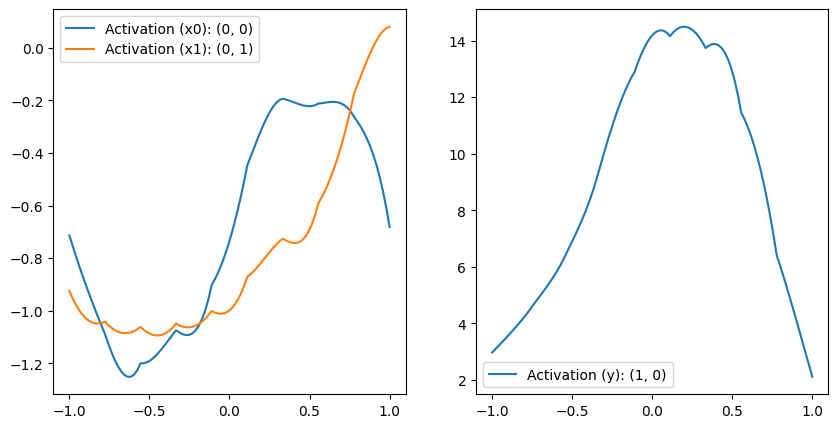

In [17]:
coefs, masks, symbolic_functions = best_model
print(f"validation loss: {best_loss: 0.5f}")

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=100)

x = torch.linspace(-1, 1, steps=100).unsqueeze(dim=1)
bases = eval_basis_functions(x, grid, k=3)

ax = axs[0]
y_out_0 = torch.einsum('ijk, bij->bk', coefs[0][0:1].transpose(2, 1), bases)
y_out_1 = torch.einsum('ijk, bij->bk', coefs[0][1:2].transpose(2, 1), bases)
ax.plot(x.numpy(), y_out_0.detach().numpy(), label="Activation (x0): (0, 0)")
ax.plot(x.numpy(), y_out_1.detach().numpy(), label="Activation (x1): (0, 1)")
ax.legend()

ax = axs[1]
y_out_final = torch.einsum('ijk, bij->bk', coefs[1].transpose(2, 1), bases)
ax.plot(x.numpy(), y_out_final.detach().numpy(), label="Activation (y): (1, 0)")

ax.legend()

### Section 2: Training KANs with activation fixed to identified Symbolic formula

Let's fix $y$ to a symbolic formula, $y^2$ or a learnable variant thereof. We do this as following --

1. We define symbolic layers that holds a potential symbolic function for that activation function
2. Upon fixing an activation function to a formula, we replace that function. We also modify `mask` to indicate where symbolic activation function is to be used. 
3. Upon the model forward, we compute all outputs for the symbolic layer using the previous layer's output. 
4. Finally, we combine the outputs using the `mask`.

Let's see how we process a symbolic layer. Here, we have two dimensions on the input and 3 dimensions for the output, i.e., We have a layer that takes in 2 inputs and outputs 3 dimensions. As a result, we have 2x3 activations, and hence symbolic functions.

### batch processing

To incorporate a fixed symbolic formula, such as \((y + 0.5)^2\), into our KAN model, we will follow these steps:

1. **Define Symbolic Layers**: Establish layers that can hold potential symbolic functions for each activation. This allows for direct embedding of known mathematical relationships.

2. **Activation Function Replacement**: Adjust the `mask` to indicate where the symbolic activation function should be used.

3. **Model Forward Pass**: During the model's forward pass, compute all outputs for the symbolic layer using the output from the previous layer. This ensures that the fixed symbolic transformations are applied correctly.

4. **Output Combination**: Use the `mask` to combine the outputs appropriately, merging the results from both the symbolic and spline-based activation functions.

### Section 2.1 Affine Transformations of Symbolic Functions

The authors proposed using symbolic activation functions so that, given a function, one only needs to learn the affine transformations of the input and the output to predict it accurately.

In [18]:
class SymbolicKANLayer(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
        # learnable parameters
        self.affine = torch.nn.Parameter(torch.zeros(4), requires_grad=True)
        
    def forward(self, x_eval):
        return self.affine[0] * self.fn(self.affine[1]*x_eval + self.affine[2]) + self.affine[3]

    def step(self, lr):
        """
        Performs a step of gradient descent using the learning rate `lr`
        """
        if self.affine.grad is not None:
            self.affine.data = self.affine.data - lr * self.affine.grad

    def zero_grad_(self):
        """
        Zeroes out the gradients in-place.
        """
        self.affine.grad.zero_()

In [19]:
# KAN setup
k = 3
grid_range = [-1, 1]
grid_size = 10
KAN = [2, 1, 1]

coefs, masks, symbolic_functions, grid = initialize_KAN(KAN, k, grid_range, grid_size)

# training hyperparameters
lr = 0.01
early_stopping_iterations = 1e4
early_stopping_imrpovement_threshold = 200

# setup the symbolic forms
# A few candidate options
# symbolic_functions, masks = set_symbolic_fn(symbolic_functions, masks, 0, 0, 0, lambda x: torch.sin(torch.pi * x), use_affine=False)
# symbolic_functions, masks = set_symbolic_fn(symbolic_functions, masks, 0, 0, 0, lambda x: torch.sin(x), use_affine=True)
# symbolic_functions, masks = set_symbolic_fn(symbolic_functions, masks, 0, 1, 0, lambda x: torch.pow(x, 2), use_affine=True)
symbolic_functions, masks = set_symbolic_fn(symbolic_functions, masks, 0, 1, 0, lambda x: torch.pow(x + 0.5, 2), use_affine=False)
# symbolic_functions, masks = set_symbolic_fn(symbolic_functions, masks, 1, 0, 0, lambda x: torch.exp(x), use_affine=False)


losses_symb = {'train': [], 'val': []}
i=0
verbose = True
best_loss = np.inf
while True:    
    # randomly shuffle indices
    shuffled_idxs = torch.randperm(x_training.shape[0])
    x = x_training[shuffled_idxs]
    y_pred = eval_KAN(x_training[shuffled_idxs], coefs, masks, symbolic_functions, grid, k)
    loss = torch.mean(torch.pow(y_pred - y_training[shuffled_idxs], 2))
    loss.backward()
    losses_symb['train'].append(loss.item())

    # backpropagate 
    for coef in coefs:
        if coef.grad is not None:
            coef.data = coef.data - lr * coef.grad
            coef.grad.zero_()

    for symb_layer in symbolic_functions:
        for neuron in symb_layer:
            for out_symb in neuron:
                if isinstance(out_symb, SymbolicKANLayer):
                    out_symb.step(lr)
                    out_symb.zero_grad_()

    with torch.no_grad():
        y_test_pred = eval_KAN(x_test, coefs, masks, symbolic_functions, grid, k)
        val_loss = torch.mean(torch.pow(y_test_pred - y_test, 2))

    losses_symb['val'].append(val_loss.item())
    
    if i% 100 == 0 and verbose:
        print(f"Val loss: {val_loss.item(): 0.5f}\tTrain loss: {loss.item(): 0.5f}\tBest Val loss:{best_loss: 0.5f}")

    if best_loss > val_loss.item():
        best_loss = val_loss.item()
        best_model = (coefs, masks, symbolic_functions)
        n_no_improvements = 0
    else:
        n_no_improvements += 1
        if n_no_improvements > early_stopping_imrpovement_threshold:
            print('Stopping: No further improvements...')
            break

    i += 1
    if i > early_stopping_iterations:
        print('Stopping: Iteration limit reached...')
        break


Val loss:  20.44826	Train loss:  22.13886	Best Val loss: inf
Val loss:  14.51404	Train loss:  15.90151	Best Val loss: 14.66091
Val loss:  7.83049	Train loss:  7.83280	Best Val loss: 7.86568
Val loss:  5.34915	Train loss:  5.03229	Best Val loss: 5.38227
Val loss:  3.90219	Train loss:  3.55946	Best Val loss: 3.91024
Val loss:  3.00045	Train loss:  2.68119	Best Val loss: 3.01492
Val loss:  2.40286	Train loss:  2.12176	Best Val loss: 2.41260
Val loss:  1.98869	Train loss:  1.73840	Best Val loss: 1.99664
Val loss:  1.62944	Train loss:  1.41676	Best Val loss: 1.65807
Val loss:  1.39518	Train loss:  1.22957	Best Val loss: 1.39941
Val loss:  1.34355	Train loss:  1.03676	Best Val loss: 1.30709
Val loss:  1.18692	Train loss:  0.93166	Best Val loss: 1.15434
Val loss:  1.05978	Train loss:  0.84724	Best Val loss: 1.02929
Val loss:  0.95709	Train loss:  0.78196	Best Val loss: 0.93166
Val loss:  0.86577	Train loss:  0.72854	Best Val loss: 0.85434
Val loss:  0.81118	Train loss:  0.68687	Best Val loss:

validation loss:  0.45285


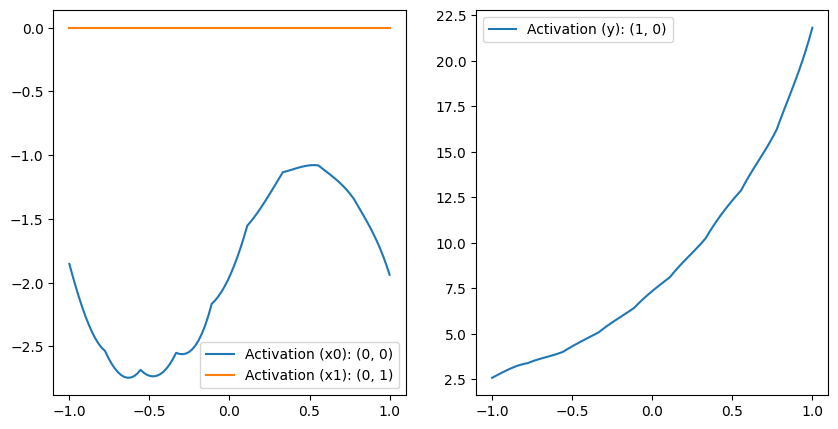

In [20]:
coefs, masks, symbolic_functions = best_model
print(f"validation loss: {best_loss: 0.5f}")

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=100)

x = torch.linspace(-1, 1, steps=100).unsqueeze(dim=1)
bases = eval_basis_functions(x, grid, k=3)

ax = axs[0]
y_out_0 = torch.einsum('ijk, bij->bk', coefs[0][0:1].transpose(2, 1), bases)
y_out_1 = torch.einsum('ijk, bij->bk', coefs[0][1:2].transpose(2, 1), bases)
ax.plot(x.numpy(), y_out_0.detach().numpy(), label="Activation (x0): (0, 0)")
ax.plot(x.numpy(), y_out_1.detach().numpy(), label="Activation (x1): (0, 1)")
ax.legend()

ax = axs[1]
y_out_final = torch.einsum('ijk, bij->bk', coefs[1].transpose(2, 1), bases)
ax.plot(x.numpy(), y_out_final.detach().numpy(), label="Activation (y): (1, 0)")

ax.legend()

**Note:** The curve for \(x2\) is zero everywhere because the coefficients for \(x2\) did not receive any gradients. This outcome is expected since we are masking all outputs related to \(x2\) with its symbolic function.

**Observation:** We observe that the other activation functions are correctly learned to match their respective functional formulations.

Text(0.5, 1.0, 'Loss')

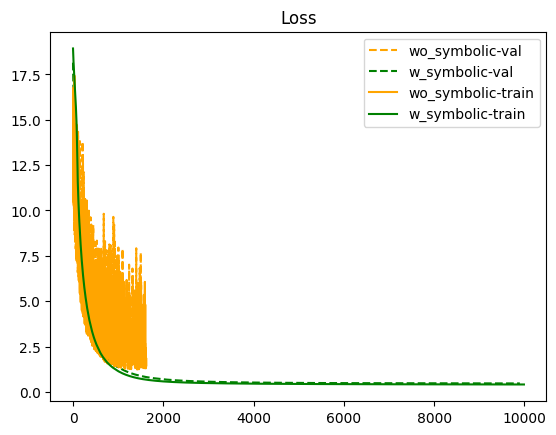

In [16]:
plt.plot(losses['val'][100:], label='wo_symbolic-val', linestyle='--', alpha=1.0, color='orange')
plt.plot(losses_symb['val'][100:], label='w_symbolic-val', linestyle='--', alpha=1.0,  color='green')

plt.plot(losses['train'][10:], label='wo_symbolic-train', linestyle='-', alpha=1.0, color='orange')
plt.plot(losses_symb['train'][10:], label='w_symbolic-train', linestyle='-', alpha=1.0,  color='green')

# plt.ylim(0,1)
plt.legend()
plt.title('Loss')

***Things to explore on your own***
1. **Varying Grid Size**: Observe how the results change when the grid size is reduced.
2. **Specific Activation Functions**: Analyze the impact of fixing the \(0,0,0\) activation to $\sin(\pi x)$
3. **Exploring Quadratic Functions**: Explore the effects of setting \(0,1,0\) activation to $(x+0.5)^2$.

***Observations***
- **Impact of Incorrect Formulas**: If an activation is incorrectly fixed to a wrong formula, it can lead to worse outcomes, rather than compensating based on other activation functions. This is particularly problematic if the KAN structure lacks sufficient capacity.
- **Noise and Symbolic Regression (SR)**: Fixing an output to a function in noisy conditions can cause other activation functions to overfit to the noise, casting doubt on the practicality of SR. Nonetheless, examining a few symbolic forms can provide valuable insights into the influence of certain variables.

## Summary

We have explored how KANs can be used to infer symbolic formulas underlying datasets throughout this notebook.


## Conclusion

Inspired by the authors' original implementation and their accompanying arXiv paper, our goal was to gradually build a foundational understanding of KANs. While the code used in these notebooks may not exactly match the original, the concepts and techniques discussed should provide a solid basis for delving deeper into the original codebase. I hope that by following this series, you have gained a clear understanding of the basics of KANs and are now equipped to explore their application across various domains.
